# Reading May and Beg. of June Data

In [2]:
%matplotlib inline
#from matplotlib import pyplot as pt
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
import pandas as pd
import seaborn as sns

import numpy as np

from datetime import datetime

import os
import glob

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data-gala/*.txt')
    all_files = glob.glob(csv_path)
    
    all_files = ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/02_turnstile_150509.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/03_turnstile_150516.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/04_turnstile_150523.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/05_turnstile_150530.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/06_turnstile_150606.txt']
    
  #  print 'reading data from files:'
  #  for f in all_files:
  #      print f
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
#data.head()


got 1152582 rows total.


# How many unique stations do we have in our set?

In [4]:
# How many stations are there?
unique_stations = data.STATION.unique()
print len(unique_stations)

384


# Transforming data: creating datetime, entries and exits diffs, and sums

In [5]:
# make a datetime column
data['DATETIME'] = pd.to_datetime(data.DATE + ' ' + data.TIME, format="%m/%d/%Y %H:%M:%S")
data.head()
data.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
191727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,05:00:00,REGULAR,5554,212,2015-06-05 05:00:00
191728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,09:00:00,REGULAR,5554,212,2015-06-05 09:00:00
191729,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,13:00:00,REGULAR,5554,212,2015-06-05 13:00:00
191730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,17:00:00,REGULAR,5554,212,2015-06-05 17:00:00
191731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,21:00:00,REGULAR,5554,212,2015-06-05 21:00:00


In [6]:
# Calclate new columns ENTRIES_DIFF and EXITS_DIFF for each unique turnstile/device.
# The first entry is NaN, the rest of the entries are the difference from the previous.
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])
for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)
data.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635,2015-04-25 00:00:00,NaN,NaN
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649,2015-04-25 04:00:00,40.0,14.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680,2015-04-25 08:00:00,25.0,31.0


In [7]:
# sanity check for getting the differences:
nan_entries = len(data[data.ENTRIES_DIFF.isnull()])
total_unique_turnstiles = len(turnstile_groupby)
print 'the number of NaN entries should equal the total unique turnstiles.'
print nan_entries, total_unique_turnstiles

assert nan_entries == total_unique_turnstiles

the number of NaN entries should equal the total unique turnstiles.
4568 4568


In [8]:
# learning how to deal with NA values
print len(data[data.ENTRIES_DIFF.isnull()])
print len(data.dropna())
print len(data)

4568
1148014
1152582


In [9]:
# dropping NA values and all non-REGULAR recordings
# calculating percentage of "regular" values vs. all nonNA values
reg_data = data.dropna()
reg_data = reg_data[ reg_data['DESC'] == 'REGULAR']
reg_data = reg_data[ reg_data['ENTRIES_DIFF'] >= 0]
reg_data = reg_data[ reg_data['ENTRIES_DIFF'] < 10000]
print len(reg_data)/float(len(data.dropna()))
print reg_data.describe()
#print reg_data[ reg_data.STATION == "14 ST-UNION SQ"].head()

0.991234427455
            ENTRIES         EXITS  ENTRIES_DIFF    EXITS_DIFF
count  1.137951e+06  1.137951e+06  1.137951e+06  1.137951e+06
mean   2.250006e+07  1.752434e+07  1.919437e+02  1.460364e+02
std    1.464737e+08  1.314242e+08  2.728390e+02  2.457107e+02
min    0.000000e+00  0.000000e+00  0.000000e+00 -5.334000e+03
25%    4.732720e+05  2.588905e+05  1.300000e+01  9.000000e+00
50%    2.250119e+06  1.352152e+06  8.500000e+01  5.700000e+01
75%    5.808430e+06  4.228290e+06  2.640000e+02  1.790000e+02
max    2.114280e+09  2.087387e+09  9.574000e+03  1.018900e+04


In [10]:
# FYI: there are about 48% of rows that are recorded at times other than 0,4,8,12,16 or 20 hours !!! 
filtered_times = reg_data[ reg_data['TIME'].isin(['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00'])]
print filtered_times['TIME'].unique()
print reg_data['TIME'].unique()
print (len(reg_data)-len(filtered_times))/float(len(reg_data))

['04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00' '00:00:00']
['04:00:00' '08:00:00' '12:00:00' ..., '19:09:21' '08:16:33' '07:37:13']
0.484922461512


# Finding Max Entries Stations

In [11]:
station_groupby = reg_data.groupby(['STATION'])
top_20 = station_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='ENTRIES_DIFF', ascending=0)
top_20 = top_20[:20]
top_20_stations = top_20.reset_index()
print top_20

                 ENTRIES_DIFF  EXITS_DIFF
STATION                                  
34 ST-PENN STA      6430463.0   5533717.0
42 ST-GRD CNTRL     5435862.0   5064471.0
34 ST-HERALD SQ     4525211.0   4070592.0
86 ST               4303861.0   3391643.0
14 ST-UNION SQ      4133901.0   3696293.0
42 ST-TIMES SQ      3801868.0   3379684.0
42 ST-PA BUS TE     3546660.0   2742142.0
96 ST               3046921.0   2025386.0
125 ST              2948904.0   2402611.0
59 ST-COLUMBUS      2832831.0   2228429.0
FULTON ST           2790816.0   2399067.0
CANAL ST            2741000.0   2188109.0
CHAMBERS ST         2603996.0   1590609.0
23 ST               2487806.0   1910272.0
59 ST               2421856.0   2014211.0
MAIN ST             2267407.0   1887297.0
47-50 ST-ROCK       2102758.0   2174243.0
72 ST               2017840.0   1489414.0
ROOSEVELT AVE       1922060.0   1515332.0
50 ST               1893964.0   1573214.0


In [12]:
top_20_entries = top_20.ENTRIES_DIFF
#print top_20_entries

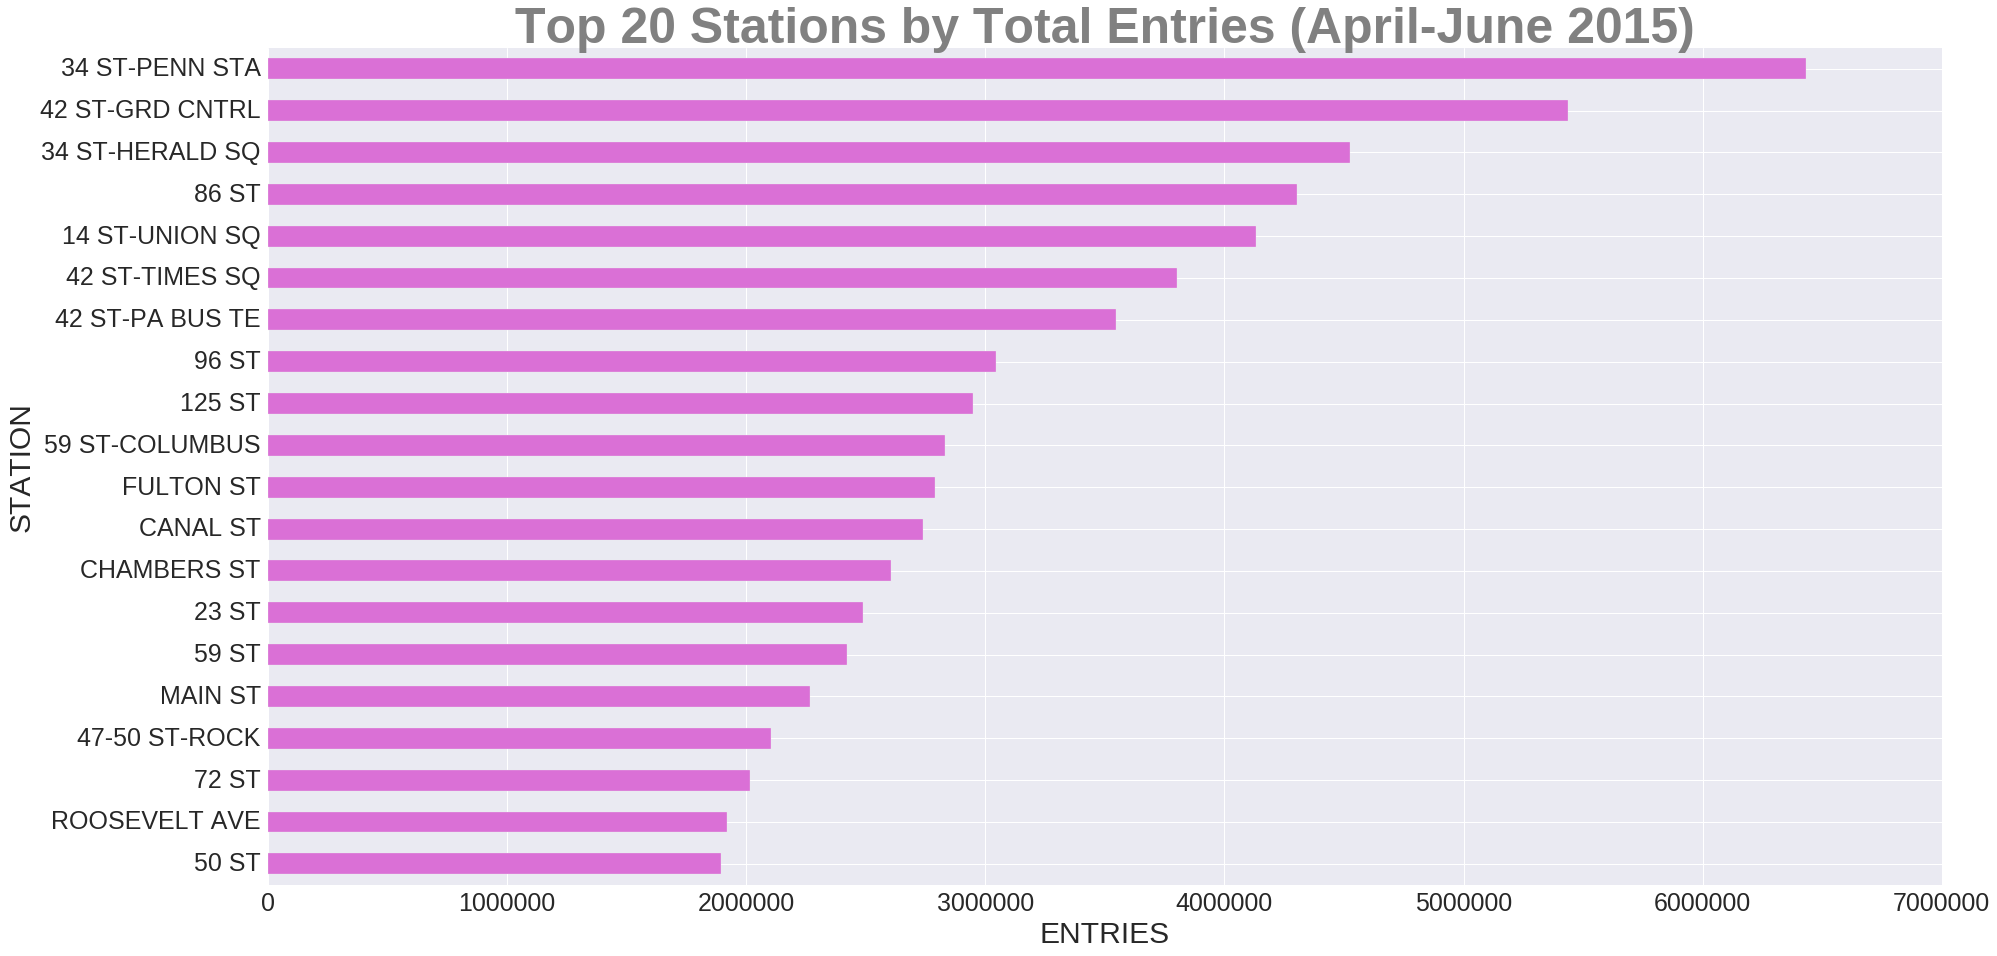

In [13]:
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.figure(figsize = (30,15))
plt.title('Top 20 Stations by Total Entries (April-June 2015)',fontsize=50, color='grey', fontweight='bold')
plt.xlabel('ENTRIES',fontsize=30)
plt.ylabel('Station',fontsize=30)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_entries.sort_values(ascending=True).plot(kind='barh', color ='orchid')
path = "figs/top_20_stations.png"
plt.savefig(path)

# Station day time heatmap

In [14]:
# Looking only at measurements that occurred at the 0,4,8,12,16,20-hour windows.
# Working with the filtered_times dataset
data_dt = filtered_times[['STATION', 'DATETIME', 'ENTRIES_DIFF','EXITS_DIFF']].reset_index()
#print data_dt.describe()
#print data_dt.head()

In [15]:
data_dt['DAY'] = data_dt['DATETIME'].dt.dayofweek
data_dt['TIME'] = data_dt['DATETIME'].dt.time
data_dt.head()

,index,STATION,DATETIME,ENTRIES_DIFF,EXITS_DIFF,DAY,TIME
0,1,LEXINGTON AVE,2015-04-25 04:00:00,40.0,14.0,5,04:00:00
1,2,LEXINGTON AVE,2015-04-25 08:00:00,25.0,31.0,5,08:00:00
2,3,LEXINGTON AVE,2015-04-25 12:00:00,126.0,104.0,5,12:00:00
3,4,LEXINGTON AVE,2015-04-25 16:00:00,289.0,74.0,5,16:00:00
4,5,LEXINGTON AVE,2015-04-25 20:00:00,370.0,56.0,5,20:00:00


In [16]:
stations_dt = data_dt.groupby(['STATION','DAY','TIME'])
all_dt = stations_dt['ENTRIES_DIFF','EXITS_DIFF'].mean()
all_dt.head(7)

ENTRIES_DIFF  EXITS_DIFF
STATION DAY TIME                              
1 AVE   0   00:00:00     84.600000   97.683333
            04:00:00     20.516667   19.983333
            08:00:00    145.033333  268.100000
            12:00:00    482.800000  528.516667
            16:00:00    464.166667  403.650000
            20:00:00    629.500000  630.733333
        1   00:00:00    312.666667  332.366667

# One station -- 1 AVE

In [17]:
print '14 ST-UNION SQ' in list(data_dt.STATION.unique())
#print data_dt.STATION.unique()

False


/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


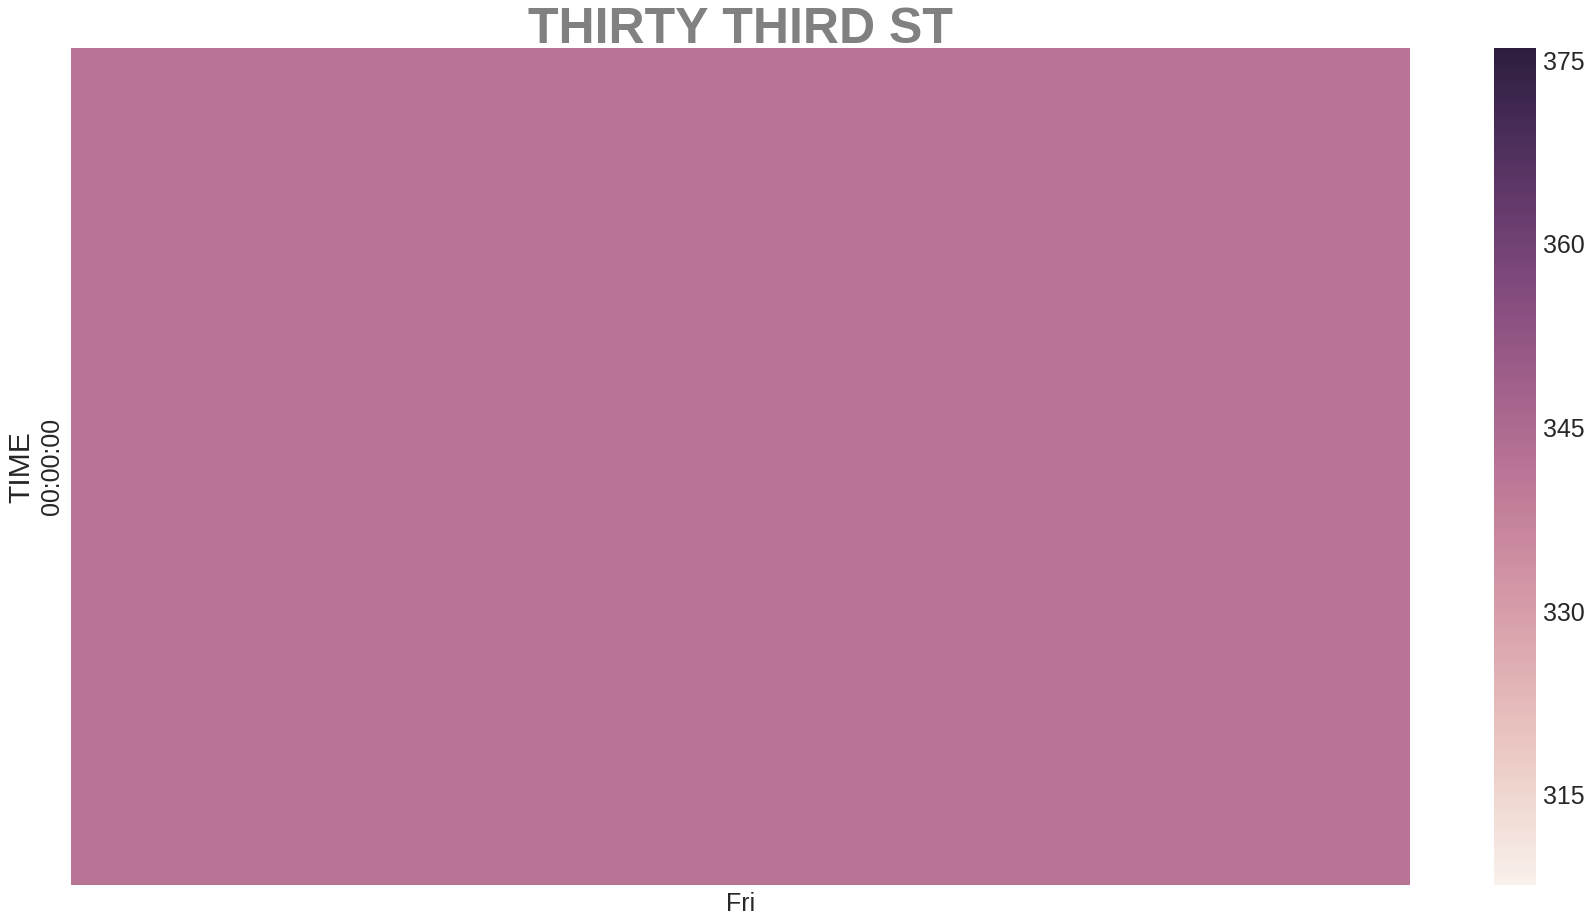

In [18]:
#station = '1 AVE' 14 ST-UNION SQ
#station = '34 ST-PENN STA'
stations = top_20_stations['STATION']
#for station in list(data_dt.STATION.unique()):
#for station in ['34 ST-PENN STA']:
for station in list(data_dt.STATION.unique()):
    #print station
    one_station = data_dt[ data_dt['STATION'] == station ]
    #print one_station.head()
    #print one_station.describe()
    one_groupby = one_station.groupby(['DAY','TIME'])
    one_dt = one_groupby['ENTRIES_DIFF'].mean().reset_index()
    #print one_dt.describe()
    # changing format of the pandas data frame from three-columns to 2-column indices and third-column as values
    # of a matrix
    one_dt_heatmap = one_dt.set_index(['DAY', 'TIME']).ENTRIES_DIFF.unstack(0)
    days_mapper = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    one_dt_heatmap.columns = [days_mapper[c] for c in one_dt_heatmap.columns]
    plt.clf()
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.figure(figsize = (30,15))
    plt.title(station, fontsize=50, color='grey', fontweight='bold')
    plt.xlabel('DAY',fontsize=30)
    plt.ylabel('TIME',fontsize=30)
    #x = range(0,7,1)
    #xLabel = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    #plt.xticks(x,xLabel)
    #fig, ax = plt.subplots(figsize=[25,10])
    sns.heatmap(one_dt_heatmap)
    stationpath = station
    if station == 'BOROUGH HALL/CT':
        stationpath = 'BOROUGH HALL-CT'
    if station == 'HOYT/SCHERMER':
        stationpath = 'HOYT-SCHERMER'
    if station == 'BEDFORD/NOSTRAN':
        stationpath = 'BEDFORD-NOSTRAN'
    if station == 'VERNON/JACKSON':
        stationpath = 'VERNON-JACKSON'
    if station == '33 ST/RAWSON ST':
        stationpath = '33 ST-RAWSON ST'
    path = "figs/heatmap_" + stationpath + ".png"
    plt.savefig(path)

# Group by station and datetime

In [19]:
# group by station name and datetime,
station_time_groupby = reg_data.groupby(['STATION','DATETIME'])

# data.join(station_time_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum(), on=['STATION','DATETIME'], rsuffix='_r')
station_time_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum().head()

ENTRIES_DIFF  EXITS_DIFF
STATION DATETIME                                     
1 AVE   2015-04-25 04:00:00           3.0        76.0
        2015-04-25 08:00:00           2.0        53.0
        2015-04-25 12:00:00           2.0        54.0
        2015-04-25 16:00:00           4.0        57.0
        2015-04-25 20:00:00           0.0        41.0

In [20]:
# The dataset also leads to many negative diff values and unreasonably high negative diff peaks (-1.4x10^9)
data[data.ENTRIES_DIFF < 0].min()

C/A                            A011
UNIT                           R007
SCP                        00-00-00
STATION                       1 AVE
LINENAME                          1
DIVISION                        BMT
DATE                     04/25/2015
TIME                       00:00:00
DESC                     RECOVR AUD
ENTRIES                           0
EXITS                             0
DATETIME        2015-04-25 04:00:00
ENTRIES_DIFF           -1.40381e+09
EXITS_DIFF             -1.11135e+07
dtype: object